## Colab Imports

In [93]:
from google.colab import drive
from google.colab import userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Installation

In [94]:
!pip -q install langgraph langchain_openai langchain_community

## Settings & Loadings

In [95]:
import os
import json

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

PROFECT_DIR = os.path.join("/content/drive/MyDrive", "Profect SAE")
CSVs = os.path.join(PROFECT_DIR, "test_data/CSVs")
files = os.listdir(CSVs)
csv_files = [
    file for file in files
      if file.endswith(".csv")
]

In [96]:
import pandas as pd

df_one = pd.read_csv(os.path.join(CSVs, csv_files[0]))

In [97]:
test_row = df_one.iloc[0]
print(test_row)

title      [종합] 김태희, 해외서 권총 강도 당했다…'연매출 1100억' 정샘물 "피해액 2...
url        https://m.entertain.naver.com/article/312/0000...
content    본문 바로가기 naver 엔터 뉴스 스포츠 사용자 링크 로그인 검색 홈 드라마 영화...
Name: 0, dtype: object


## Models to use
- `gpt-4o-mini`

In [98]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

## Nodes

### Schema

In [99]:
from pydantic import BaseModel, Field
from typing import Optional, List

class RequestDto(BaseModel):
  title: str = Field(..., min_length=1)
  url: str = Field(..., min_length=5, max_length=2083)
  content: str = Field(..., min_length=1)

### Preprocessing Agent

In [100]:
import re
from typing import Literal

# Routing Node
def preprocessing_agent(requestDto: RequestDto) -> dict:
    youtube_pattern = r"^https?://(www\.)?youtube\.com"
    naver_news_pattern = r"^https?://n\.news\.naver\.com"
    naver_entertainment_pattern = r"^https?://m\.entertain\.naver\.com"
    naver_sports_pattern = r"^https?://m\.sports\.naver\.com"

    if re.match(youtube_pattern, requestDto.url):
        route = "youtube_preprocessing"

    elif re.match(naver_news_pattern, requestDto.url):
        route = "naver_news_preprocessing"

    elif re.match(naver_entertainment_pattern, requestDto.url):
        route = "naver_entertainment_preprocessing"

    elif re.match(naver_sports_pattern, requestDto.url):
        route = "naver_sports_preprocessing"

    else:
        route = "default_preprocessing"

    # Add route to the requestDto and return as a dictionary
    return {"requestDto": requestDto, "route": route}


# Preprocessing Nodes
def naver_news_preprocessing(requestDto):
  return requestDto

def naver_entertainment_preprocessing(requestDto):
  return requestDto

def naver_sports_preprocessing(requestDto):
  return requestDto

def youtube_preprocessing(requestDto):
  return requestDto

def default_preprocessing(requestDto):
  return requestDto

### Retriever Agent

In [106]:
def retriever_agent(requestDto):
  print(requestDto.url)
  return None

## State

## Flow

In [108]:
from langgraph.graph import Graph, START, END

workflow = Graph()

# Registring nodes
workflow.add_node("preprocessing_agent", preprocessing_agent)
workflow.add_node("naver_news_preprocessing", naver_news_preprocessing)
workflow.add_node("naver_entertainment_preprocessing", naver_entertainment_preprocessing)
workflow.add_node("naver_sports_preprocessing", naver_sports_preprocessing)
workflow.add_node("youtube_preprocessing", youtube_preprocessing)
workflow.add_node("default_preprocessing", default_preprocessing)
workflow.add_node("retriever_agent", retriever_agent)


# Registring edges
workflow.add_edge(START, "preprocessing_agent")

## Conditional edges
workflow.add_conditional_edges(
    "preprocessing_agent",
    lambda output: output["route"],
    {
        "naver_news_preprocessing": "naver_news_preprocessing",
        "naver_entertainment_preprocessing": "naver_entertainment_preprocessing",
        "naver_sports_preprocessing": "naver_sports_preprocessing",
        "youtube_preprocessing": "youtube_preprocessing",
        "default_preprocessing": "default_preprocessing",
    }
)

workflow.add_edge("naver_news_preprocessing", "retriever_agent")
workflow.add_edge("naver_entertainment_preprocessing", "retriever_agent")
workflow.add_edge("naver_sports_preprocessing", "retriever_agent")
workflow.add_edge("youtube_preprocessing", "retriever_agent")
workflow.add_edge("default_preprocessing", "retriever_agent")
workflow.add_edge("retriever_agent", END)

# Compiling
app = workflow.compile()

In [ ]:
for test_row in df_one.itertuples():
  app.invoke(RequestDto(title=test_row.title, url=test_row.url, content=test_row.content))

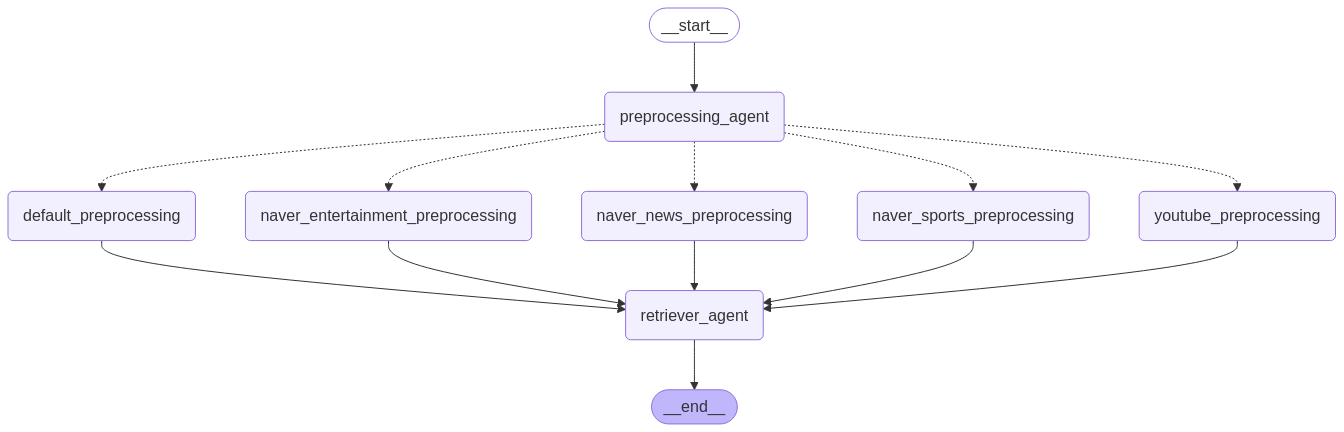

In [104]:
# Visualize your graph
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()

display(Image(png))